In [1]:
# Basic imports
import os
import shutil
import random
from PIL import Image, ImageFile
import torch
from random import choice
from IPython.display import FileLink
import seaborn as sns
import subprocess
import matplotlib.image as mpimg
import cv2
from matplotlib.gridspec import GridSpec

# Import needed for ML on CNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms

2024-05-27 13:18:40.377129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 13:18:40.377240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 13:18:40.513668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

## Function to merge directories

In [2]:
def merge_folders(train_path, test_path, merged_path):
    if not os.path.exists(merged_path):
        os.makedirs(merged_path)

    for folder in os.listdir(train_path):
        train_class_path = os.path.join(train_path, folder)
        test_class_path = os.path.join(test_path, folder)
        merged_class_path = os.path.join(merged_path, folder)

        if not os.path.exists(merged_class_path):
            os.makedirs(merged_class_path)

        for file_name in os.listdir(train_class_path):
            file_path = os.path.join(train_class_path, file_name)
            shutil.copy(file_path, merged_class_path)

        for file_name in os.listdir(test_class_path):
            file_path = os.path.join(test_class_path, file_name)
            shutil.copy(file_path, merged_class_path)

# Example usage on kaggle
train_folder_path = '/kaggle/input/polish-traffic-signs-dataset/test'
test_folder_path = '/kaggle/input/polish-traffic-signs-dataset/train'
merged_folder_path = '/kaggle/working/dataset'

merge_folders(train_folder_path, test_folder_path, merged_folder_path)

## Function to count images per traffic sign class

In [3]:
def count_files_per_class(folder_path):
    class_counts = {}
    total_classes = 0
    total_files = 0

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            file_count = len(os.listdir(class_path))
            class_counts[class_name] = file_count
            total_classes += 1
            total_files += file_count

    return class_counts, total_classes, total_files

## Function for plotting that count of imgages in all classes

In [4]:
def plot_bar_chart(class_counts):
    plt.figure(figsize=(15, 8))
    plt.bar(class_counts.keys(), class_counts.values(), color='purple')
    plt.title('Liczba plików dla każdej z klas', fontsize=16)
    plt.xlabel('Klasy', fontsize=14)
    plt.ylabel('Liczba plików', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [5]:
folder_path = '/kaggle/working/dataset'

class_counts, total_classes, total_files = count_files_per_class(folder_path)
print("Liczba klas:", total_classes)
print("Liczba plików łącznie:", total_files)

Liczba klas: 92
Liczba plików łącznie: 21032


## The plot of images count in every class

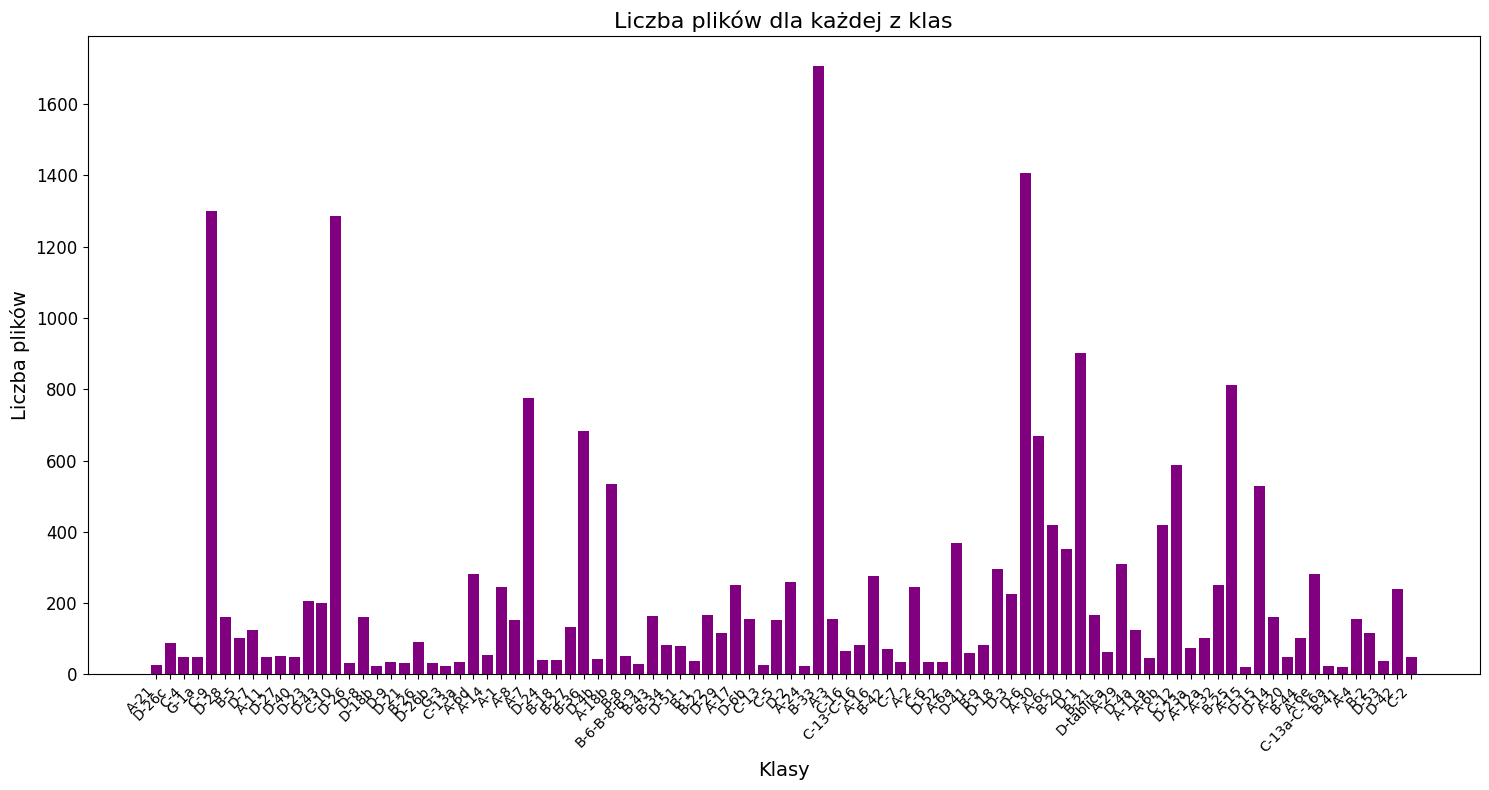

In [6]:
plot_bar_chart(class_counts)

# My dataset is unbalanced — I need a more balanced number of images in each category.
I decided that 300 images per category is sufficient, so I will augment categories with fewer than 300 images. However, some categories have very few images in their folders... Augmenting these small folders could negatively affect model training, so I remove all folders with fewer than 100 images.
As a result, my model will recognize fewer traffic sign categories, but it will do so more accurately (based on my previous experiments training on an unbalanced dataset).

## Function to remove categories belowe 100 images

In [7]:
def remove_categories(root_dir, threshold):
    categories = os.listdir(root_dir)
    
    for category in categories:
        num_of_images = len(os.listdir(os.path.join(root_dir, category)))
        if num_of_images < threshold:
            shutil.rmtree(os.path.join(root_dir, category))

## Function to augment images inside one specific class

In [8]:
def augment_images(image_dir, target_count):
    images = os.listdir(image_dir)
    num_images = len(images)
    
    datagen = ImageDataGenerator(
        rotation_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.5, 1.5],
        channel_shift_range=30,
    )
    
    # augment images until target_count is reached
    while len(os.listdir(image_dir)) < target_count:
        images = os.listdir(image_dir)
        for image_name in images:
            # Skip images that are already augmented
            if 'augmented' in image_name:
                continue
            
            # choosing image to augment
            image_path = os.path.join(image_dir, image_name)
            img = load_img(image_path)
            # image to array
            x = img_to_array(img)
            # We need to add 4th dimension to the picture (it changes nothing visually)
            x = x.reshape((1,) + x.shape)
            for batch in datagen.flow(
                x, 
                batch_size=1, 
                save_to_dir=image_dir, 
                save_prefix='augmented', 
                save_format='jpg'):
                break  # Augment only one image per original image

    # remove excess images if there are too many after augmentation
    images = os.listdir(image_dir)
    num_images = len(images)
    if num_images > target_count:
        excess_images = images[target_count:]
        for image in excess_images:
            os.remove(os.path.join(image_dir, image))
    

def augment_categories(root_dir, target_num):
    for category in os.listdir(root_dir):
        category_dir = os.path.join(root_dir, category)
        if os.path.isdir(category_dir):
            augment_images(category_dir, target_num)

## Look at Data after augmentation 

In [9]:
remove_categories(folder_path, 100)
augment_categories(folder_path, 300)

In [10]:
class_counts, total_classes, total_files = count_files_per_class(folder_path)
print("Liczba klas:", total_classes)
print("Liczba plików łącznie:", total_files)

Liczba klas: 49
Liczba plików łącznie: 14700


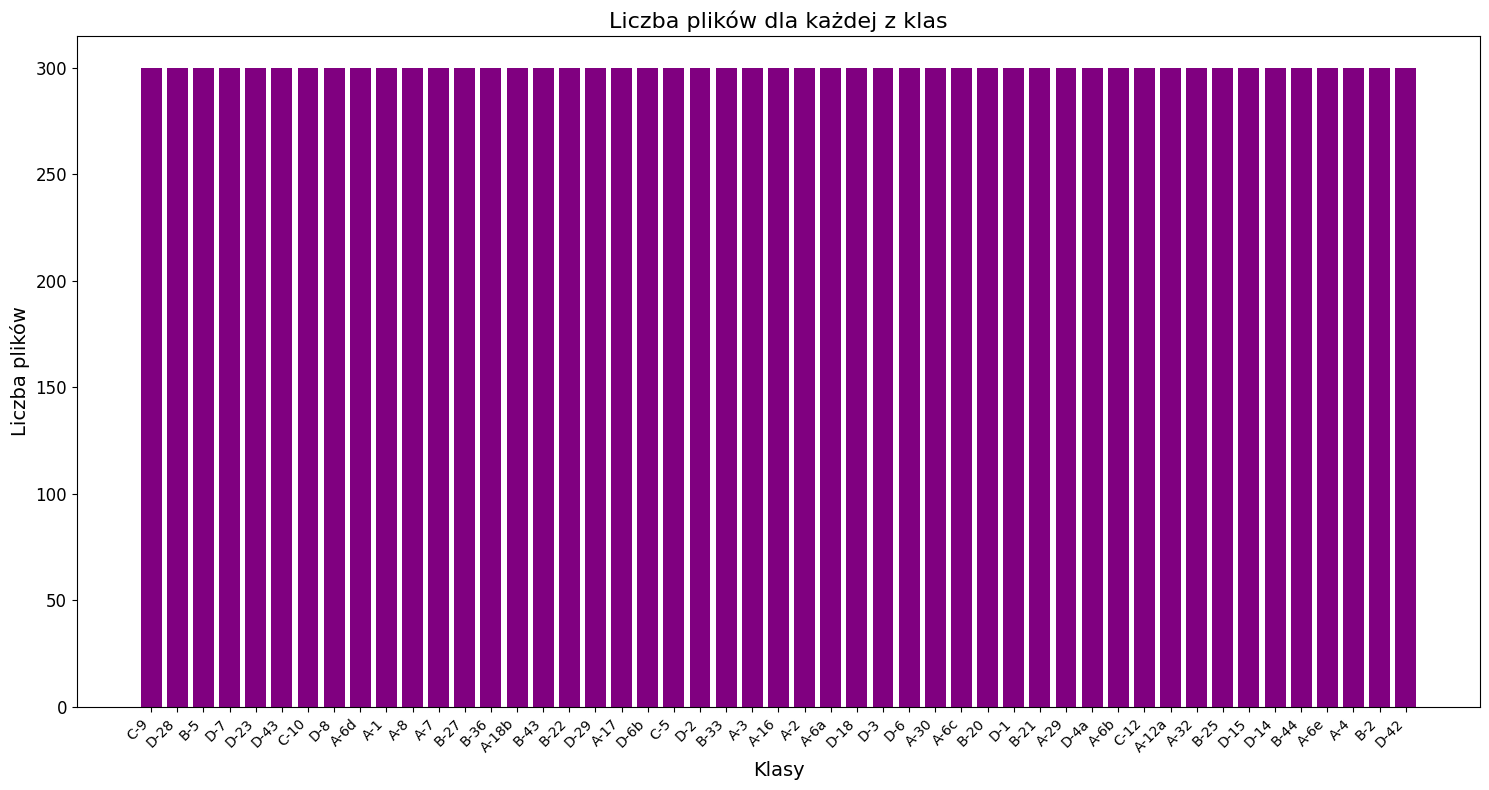

In [11]:
plot_bar_chart(class_counts)

## I split the dataset into Training (60%), Validation (20%), and Testing (20%) sets.
This is done separately for each category using the built-in train_test_split function.

In [12]:
def split_dataset(root_dir, train_dir, val_dir, test_dir, train_size=0.6, val_size=0.2, test_size=0.2):
    categories = os.listdir(root_dir)

    for category in categories:
        category_dir = os.path.join(root_dir, category)
        if os.path.isdir(category_dir):
            files = os.listdir(category_dir)
            train_files, test_val_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_val_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_category_dir = os.path.join(train_dir, category)
            os.makedirs(train_category_dir, exist_ok=True)
            for file in train_files:
                if os.path.isfile(os.path.join(category_dir, file)):
                    shutil.copy(os.path.join(category_dir, file), os.path.join(train_category_dir, file))

            val_category_dir = os.path.join(val_dir, category)
            os.makedirs(val_category_dir, exist_ok=True)
            for file in val_files:
                if os.path.isfile(os.path.join(category_dir, file)):
                    shutil.copy(os.path.join(category_dir, file), os.path.join(val_category_dir, file))

            test_category_dir = os.path.join(test_dir, category)
            os.makedirs(test_category_dir, exist_ok=True)
            for file in test_files:
                if os.path.isfile(os.path.join(category_dir, file)):
                    shutil.copy(os.path.join(category_dir, file), os.path.join(test_category_dir, file))
                    
    for directory in os.listdir(root_dir):
        if directory not in ['train', 'val', 'test']:
            shutil.rmtree(os.path.join(root_dir, directory))

    print("Usunięto foldery, oprócz train, val i test.")

In [13]:
root_dir = '/kaggle/working/dataset'
train_dir = '/kaggle/working/dataset/train'
val_dir = '/kaggle/working/dataset/val'
test_dir = '/kaggle/working/dataset/test'

split_dataset(root_dir, train_dir, val_dir, test_dir)
print("Podział danych został zakończony pomyślnie.")

Usunięto foldery, oprócz train, val i test.
Podział danych został zakończony pomyślnie.


## Traning Dataset

In [14]:
train_class_counts, train_total_classes, train_total_files = count_files_per_class('/kaggle/working/dataset/train')
print("Liczba klas:", train_total_classes)
print("Liczba plików łącznie:", train_total_files)

Liczba klas: 49
Liczba plików łącznie: 8820


## Validation Dataset

In [15]:
val_class_counts, val_total_classes, val_total_files = count_files_per_class('/kaggle/working/dataset/val')
print("Liczba klas:", val_total_classes)
print("Liczba plików łącznie:", val_total_files)

Liczba klas: 49
Liczba plików łącznie: 2940


## Test Dataset

In [16]:
test_class_counts, test_total_classes, test_total_files = count_files_per_class('/kaggle/working/dataset/test')
print("Liczba klas:", test_total_classes)
print("Liczba plików łącznie:", test_total_files)

Liczba klas: 49
Liczba plików łącznie: 2940


## Creating data generators
One of many ways to prepare a dataset ready for training, organized into classes in separate subfolders. The only thing we forgot to do is rescale the images to a uniform size. I decided to use 32x32 pixels.

In [17]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
)

val_image_generator = ImageDataGenerator(
    rescale=1./255,
)

test_image_generator = ImageDataGenerator(
    rescale=1./255,
)

In [18]:
train_data_generator = train_image_generator.flow_from_directory(
    batch_size = 64,
    directory = '/kaggle/working/dataset/train',
    class_mode = 'sparse',
    shuffle = True,
    target_size=(32,32)
)

val_data_generator = val_image_generator.flow_from_directory(
    batch_size = 64,
    directory = '/kaggle/working/dataset/val',
    class_mode = 'sparse',
    shuffle = False,
    target_size=(32,32)
)

test_data_generator = test_image_generator.flow_from_directory(
    batch_size = 64,
    directory = '/kaggle/working/dataset/test',
    class_mode = 'sparse',
    shuffle = False,
    target_size=(32,32)
)

Found 8820 images belonging to 49 classes.
Found 2940 images belonging to 49 classes.
Found 2940 images belonging to 49 classes.


# Convolutional Neural Netowork

In [20]:
model = Sequential([
     Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', kernel_regularizer=l2(0.001)), 
     Conv2D(32, (5, 5), activation='relu', kernel_regularizer=l2(0.001)),
     MaxPooling2D(pool_size=(2, 2)),
     Dropout(0.2),
    
     Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
     Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
     MaxPooling2D(pool_size=(2, 2)),
     Dropout(0.2),
    
     Flatten(),
     Dense(294, activation='relu'),
     Dropout(0.2),
     Dense(49, activation='softmax')
])

model.compile(Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator, 
    epochs=16,
    validation_data=val_data_generator,
    verbose=1,
)

Epoch 1/16


KeyboardInterrupt: 

## Can also load already trained model by me

In [19]:
model = load_model('/kaggle/input/cnn/tensorflow2/best/1/model_best.h5')

In [20]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_136 (Conv2D)             │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 294)            │       301,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 294)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 49)             │        14,455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 399,295 (1.52 MB)

 Trainable params: 399,293 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Training results on the graph (loss function and accuracy)

In [21]:
def acc_loss_eval(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(15, 6))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color="green", label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, color="#8aff80", label='Validation Accuracy', linewidth=2)
    plt.ylim(0, 1)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color="purple", label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, color="pink", label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
acc_loss_eval(history)

## Prediction and evaluation of accuracy on the test set

In [22]:
predictions = model.predict(test_data_generator)
predicted_classes = predictions.argmax(axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

I0000 00:00:1716816370.191616     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
              precision    recall  f1-score   support

         A-1       0.98      0.98      0.98        60
       A-12a       0.98      0.95      0.97        60
        A-16       0.92      0.92      0.92        60
        A-17       0.97      0.95      0.96        60
       A-18b       1.00      1.00      1.00        60
         A-2       1.00      1.00      1.00        60
        A-29       1.00      1.00      1.00        60
         A-3       1.00      0.97      0.98        60
        A-30       0.84      0.98      0.91        60
        A-32       0.92      1.00      0.96        60
         A-4       1.00      1.00      1.00        60
        A-6a       1.00      0.93      0.97        60
        A-6b       0.98      0.97      0.97        60
        A-6c       0.97      0.97      0.97        60
        A-6d       0.98      0.98      0.98        60
        A-6e       1.00      0.88      0.94        60
         A-7       1.00      0.98      0.

In [23]:
class_names = {
            'A-1': 'Niebezpieczny zakręt w prawo',
            'A-11': 'Nierówna droga',
            'A-11a': 'Próg zwalniający',
            'A-12a': 'Zwężenie jezdni - dwustronne',
            'A-14': 'Roboty drogowe',
            'A-15': 'Śliska jezdnia',
            'A-16': 'Przejście dla pieszych',
            'A-17': 'Dzieci',
            'A-18b': 'Zwierzęta dzikie',
            'A-2': 'Niebezpieczny zakręt w lewo',
            'A-20': 'Odcinek jezdni o ruchu dwukierunkowym',
            'A-21': 'Tramwaj',
            'A-24': 'Rowerzyści',
            'A-29': 'Sygnały świetlne',
            'A-3': 'Niebezpieczne zakręty, pierwszy w prawo',
            'A-30': 'Inne niebezpieczeństwo',
            'A-32': 'Oszronienie jezdni',
            'A-4': 'Niebezpieczne zakręty, pierwszy w lewo',
            'A-6a': 'Skrzyżowanie z drogą podporządkowaną występującą po obu stronach',
            'A-6b': 'Skrzyżowanie z drogą podporządkowaną występującą po prawej stronie',
            'A-6c': 'Skrzyżowanie z drogą podporządkowaną występującą po lewej stronie',
            'A-6d': 'Wlot drogi jednokierunkowej z prawej strony',
            'A-6e': 'Wlot drogi jednokierunkowej z lewej strony',
            'A-7': 'Ustąp pierwszeństwa',
            'A-8': 'Skrzyżowanie o ruchu okrężnym',
            'B-1': 'Zakaz ruchu w obu kierunkach',
            'B-18': 'Zakaz wjazdu pojazdów o rzeczywistej masie całkowitej ponad ... t.',
            'B-2': 'Zakaz wjazdu',
            'B-20': 'STOP',
            'B-21': 'Zakaz skręcania w lewo',
            'B-22': 'Zakaz skręcania w prawo',
            'B-25': 'Zakaz wyprzedzania',
            'B-26': 'Zakaz wyprzedzania przez samochody ciężarowe',
            'B-27': 'Koniec zakazu wyprzedzania',
            'B-33': 'Ograniczenie prędkości',
            'B-34': 'Koniec ograniczenia prędkości',
            'B-36': 'Zakaz zatrzymywania się',
            'B-41': 'Zakaz ruchu pieszych',
            'B-42': 'Koniec zakazów',
            'B-43': 'Strefa ograniczonej prędkości',
            'B-44': 'Koniec strefy ograniczonej prędkości',
            'B-5': 'Zakaz wjazdu samochodów ciężarowych',
            'B-6-B-8-B-9': 'Zakaz wjazdu pojazdów innych niż samochodowe',
            'B-8': 'Zakaz wjazdu pojazdów zaprzęgowych',
            'B-9': 'Zakaz wjazdu rowerów',
            'C-10': 'Nakaz jazdy z lewej strony znaku',
            'C-12': 'Ruch okrężny',
            'C-13': 'Droga dla rowerów',
            'C-13-C-16': 'Droga dla pieszych i rowerzystów',
            'C-13a': 'Koniec drogi dla rowerów',
            'C-13a-C-16a': 'Koniec drogi dla pieszych i rowerzystów',
            'C-16': 'Droga dla pieszych',
            'C-2': 'Nakaz jazdy w prawo za znakiem',
            'C-4': 'Nakaz jazdy w lewo za znakiem',
            'C-5': 'Nakaz jazdy prosto',
            'C-6': 'Nakaz jazdy prosto lub w prawo',
            'C-7': 'Nakaz jazdy prosto lub w lewo',
            'C-9': 'Nakaz jazdy z prawej strony znaku',
            'D-1': 'Droga z pierwszeństwem',
            'D-14': 'Koniec pasa ruchu',
            'D-15': 'Przystanek autobusowy',
            'D-18': 'Parking',
            'D-18b': 'Parking zadaszony',
            'D-2': 'Koniec drogi z pierwszeństwem',
            'D-21': 'Szpital',
            'D-23': 'Stacja paliwowa',
            'D-23a': 'Stacja paliwowa tylko z gazem do napędu pojazdów',
            'D-24': 'Telefon',
            'D-26': 'Stacja obsługi technicznej',
            'D-26b': 'Myjnia',
            'D-26c': 'Toaleta publiczna',
            'D-27': 'Bufet lub kawiarnia',
            'D-28': 'Restauracja',
            'D-29': 'Hotel (motel)',
            'D-3': 'Droga jednokierunkowa',
            'D-40': 'Strefa zamieszkania',
            'D-41': 'Koniec strefy zamieszkania',
            'D-42': 'Obszar zabudowany',
            'D-43': 'Koniec obszaru zabudowanego',
            'D-4a': 'Droga bez przejazdu',
            'D-4b': 'Wjazd na drogę bez przejazdu',
            'D-51': 'Automatyczna kontrola prędkości',
            'D-52': 'Strefa ruchu',
            'D-53': 'Koniec strefy ruchu',
            'D-6': 'Przejście dla pieszych',
            'D-6b': 'Przejście dla pieszych i przejazd dla rowerzystów',
            'D-7': 'Droga ekspresowa',
            'D-8': 'Koniec drogi ekspresowej',
            'D-9': 'Autostrada',
            'D-tablica': 'Zbiorcza tablica informacyjna',
            'G-1a': 'Słupek wskaźnikowy z trzema kreskami umieszczany po prawej stronie jezdni',
            'G-3': 'Krzyż św. Andrzeja przed przejazdem kolejowym jednotorowym'
        }

## Confusion Matrix

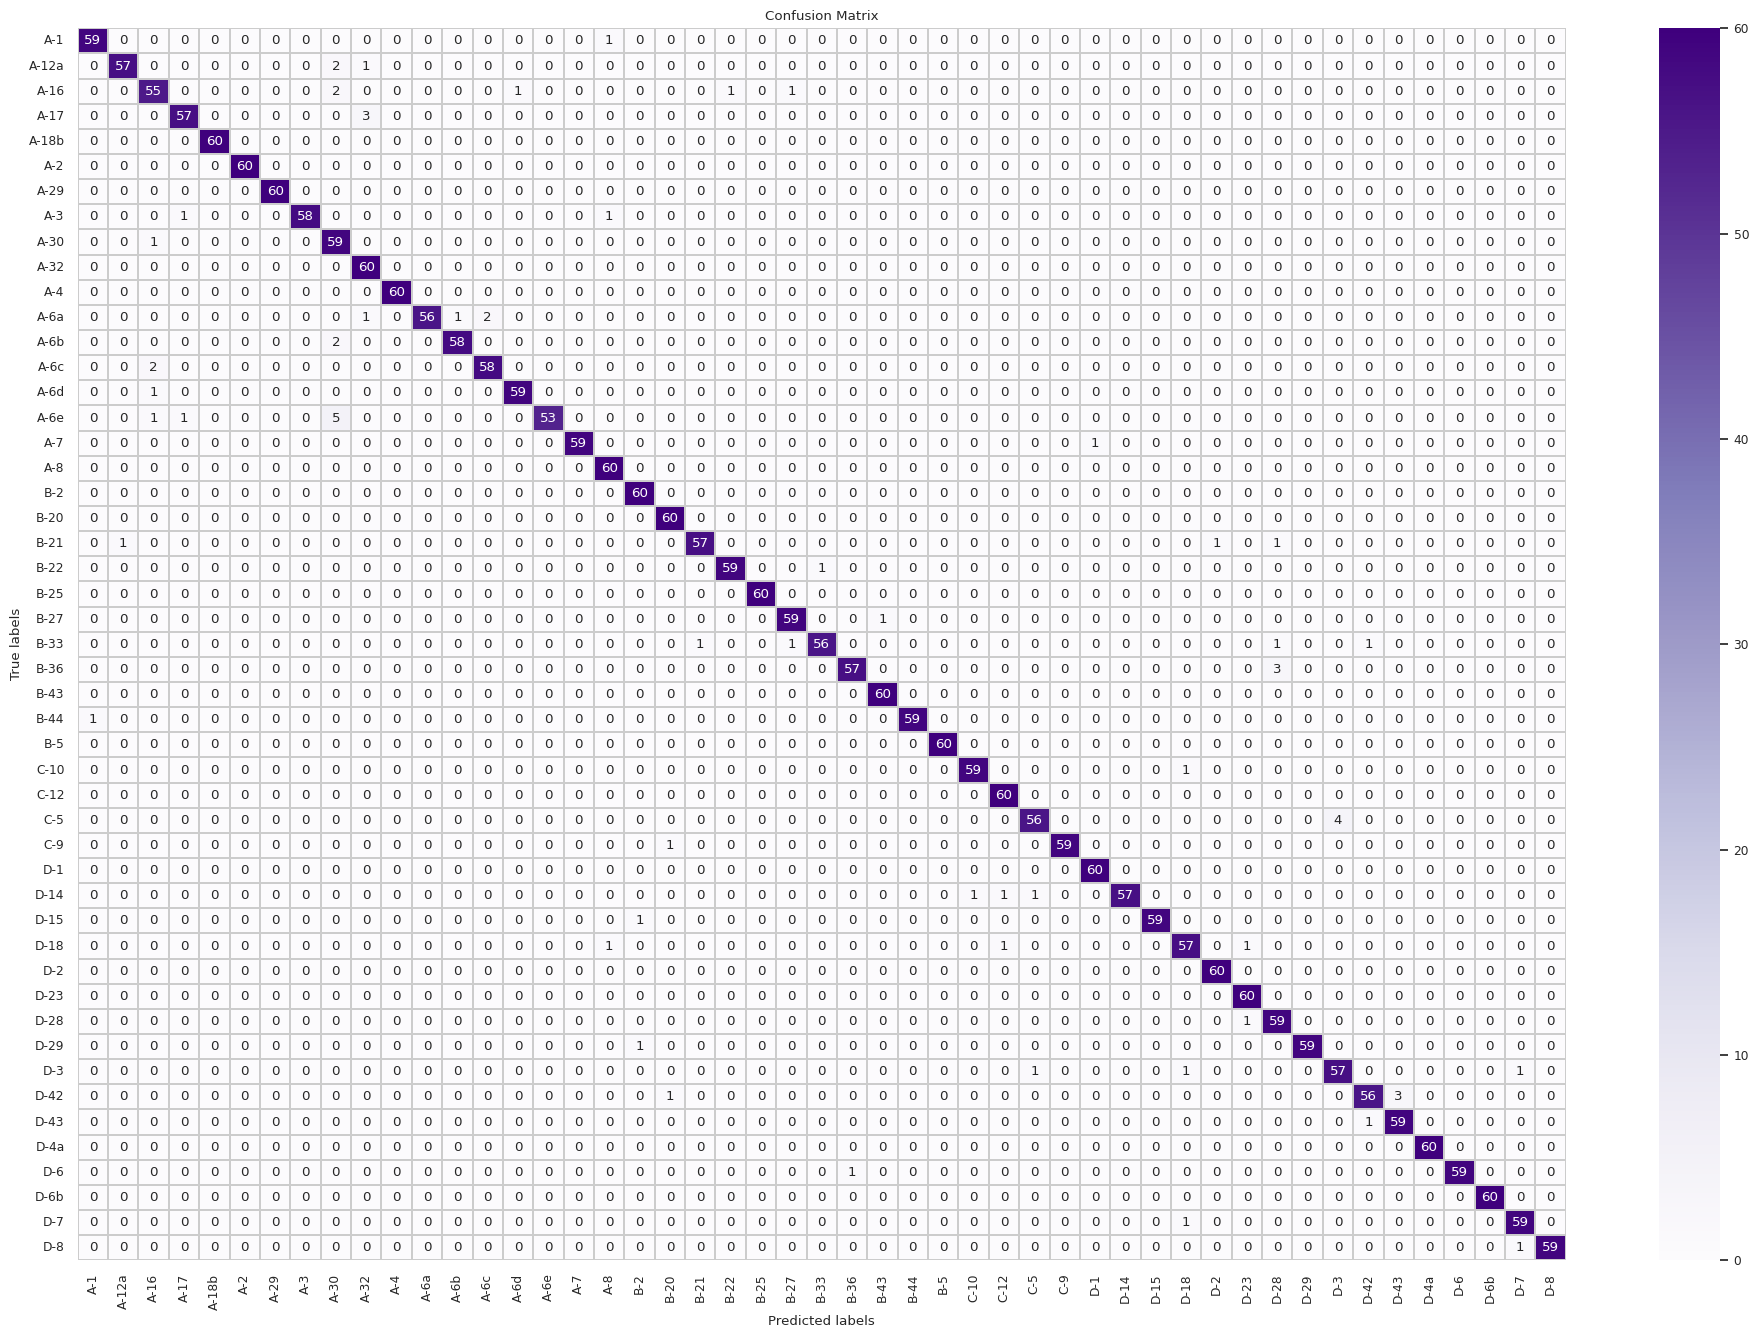

In [24]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(24, 16))
sns.set(font_scale=0.8)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', linewidths=0.1, linecolor='#CCCCCC', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Testing all models at once

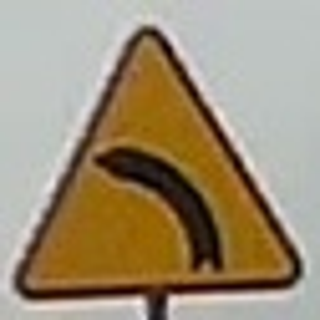

Sign is: A-2 Model predicted: A-2 | Class name: Niebezpieczny zakręt w lewo


In [25]:
test_folder_path = "/kaggle/working/dataset/test"
subfolders = [folder for folder in os.listdir(test_folder_path) if os.path.isdir(os.path.join(test_folder_path, folder))]
random_subfolder = random.choice(subfolders)
random_subfolder_path = os.path.join(test_folder_path, random_subfolder)
files_in_subfolder = os.listdir(random_subfolder_path)
random_image_file = random.choice(files_in_subfolder)

random_image_path = os.path.join(random_subfolder_path, random_image_file)

random_image = Image.open(random_image_path)
display(random_image.resize((320, 320)))

image = Image.open(random_image_path)
image = image.resize((32,32))
image_array = np.array(image.convert('RGB'))
image_array.shape = (1, 32, 32, 3)
result = model.predict(image_array, verbose=0)

predicted_class_index = np.argmax(result)
predicted_class_name = list(test_data_generator.class_indices.keys())[predicted_class_index]
predicted_class_name_desc = class_names[predicted_class_name]
        
print(f'Sign is: {random_subfolder} Model predicted: {predicted_class_name} | Class name: {predicted_class_name_desc}')

## Using YOLOv8 for detection and cropping

In [26]:
orig_dataset_dir = "/kaggle/input/d/chriskjm/polish-traffic-signs-dataset"
prepared_dataset_dir = "/kaggle/working/datasets/"

In [27]:
detection_images_dir = os.path.join(orig_dataset_dir, "detection/imgs")
detection_labels_dir = os.path.join(orig_dataset_dir, "detection/labels")

detection_train_dir = os.path.join(prepared_dataset_dir, "detection/train")
detection_val_dir = os.path.join(prepared_dataset_dir, "detection/val")
detection_test_dir = os.path.join(prepared_dataset_dir, "detection/test")

# shuffle the data
data = os.listdir(detection_images_dir)
random.shuffle(data)

# 70-10-20 data split
train_data = data[:7 * len(data) // 10]
val_data = data[7 * len(data) // 10: 8 * len(data) // 10]
test_data = data[8 * len(data) // 10:]


def copy_data(data, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # assuming the label file name is the same as image file name
    for image_file_name in data:
        image_path = os.path.join(detection_images_dir, image_file_name)
        label_path = os.path.join(detection_labels_dir, os.path.splitext(image_file_name)[0] + ".txt")
        
        # copy the data into a new folder
        shutil.copy(image_path, target_dir)
        shutil.copy(label_path, target_dir)


# split data into different folders
copy_data(train_data, detection_train_dir)
copy_data(val_data, detection_val_dir)
copy_data(test_data, detection_test_dir)

In [28]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 23.9 MB/s eta 0:00:00


In [29]:
from ultralytics import YOLO
model_yolo = YOLO("/kaggle/input/yolov8/tensorflow2/v1/1/best.pt")

In [30]:
# Ścieżka do katalogu z plikami JPG i TXT
directory_path = '/kaggle/working/datasets/detection/test/'

# Uzyskanie listy plików JPG w katalogu
jpg_files = [file for file in os.listdir(directory_path) if file.endswith('.jpg')]

# Wybór losowego pliku JPG
random_jpg_file = random.choice(jpg_files)

random_jpg_file_path = directory_path + random_jpg_file

print("Losowo wybrany plik JPG:", random_jpg_file_path)

Losowo wybrany plik JPG: /kaggle/working/datasets/detection/test/460.jpg


## Function to save results

In [31]:
def crop_and_save_objects(image_path, model_yolo):
    # Ścieżka do foldera z wyciętymi obiektami
    output_folder = '/kaggle/working/cropped_objects/'
    
    # Usuwamy zawartość foldera detected_objects, jeśli istnieje
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    
    # Tworzymy folder dla wyciętych obiektów
    os.makedirs(output_folder)

    # Wykonujemy predykcję
    results = model_yolo(image_path)
    
    # Printujemy zdjęcie
    cropped_images = []
    
    # Pobieramy detekcje
    for idx, det in enumerate(results):
        image = det.path
        for box_idx, box in enumerate(det.boxes):
            xyxy = box.xyxy.tolist()

            x1, y1, x2, y2 = xyxy[0]  # Wartości xmin, ymin, xmax, ymax
        
            # Wycinamy obiekt z oryginalnego obrazu
            object_image = Image.open(image_path)
            object_image = object_image.crop((x1, y1, x2, y2))

            # Zapisujemy wycięty obiekt
            object_filename = os.path.join(output_folder, f"object_{idx}_{box_idx}.jpg")
            object_image.save(object_filename)

            # Dodajemy wycięty obiekt do listy
            cropped_images.append(object_filename)
    
    return cropped_images

# Wrapper for hybrid model

In [32]:
def predict_with_hybrid_model(random_image_path):
    random_image = Image.open(random_image_path)
    display(random_image)
    
    model_yolo = YOLO("/kaggle/input/yolov8/tensorflow2/v1/1/best.pt")
    cropped_images_list = crop_and_save_objects(random_image_path, model_yolo)
    
    model_cnn = load_model('/kaggle/input/cnn/tensorflow2/best/1/model_best.h5')
    
    for cropped_image_path in cropped_images_list:
        cropped_image = Image.open(cropped_image_path)
        display(cropped_image.resize((320, 320)))
        resized_cropped_image = cropped_image.resize((32, 32))
        image_array = np.array(resized_cropped_image.convert('RGB'))
        image_array.shape = (1, 32, 32, 3)
        result = model_cnn.predict(image_array, verbose=0)

        predicted_class_index = np.argmax(result)

        predicted_class_name = list(test_data_generator.class_indices.keys())[predicted_class_index]

        predicted_class_name_desc = class_names[predicted_class_name]

        print('----------------------------------------------------------------------------------')
        print(f'Model predicted: {predicted_class_name} | Class name: {predicted_class_name_desc}')
        print('----------------------------------------------------------------------------------')

In [33]:
directory_path = '/kaggle/working/datasets/detection/test/'
jpg_files = [file for file in os.listdir(directory_path) if file.endswith('.jpg')]
random_jpg_file = random.choice(jpg_files)
random_jpg_file_path = directory_path + random_jpg_file

print("Losowo wybrany plik JPG:", random_jpg_file_path)

Losowo wybrany plik JPG: /kaggle/working/datasets/detection/test/1271.jpg


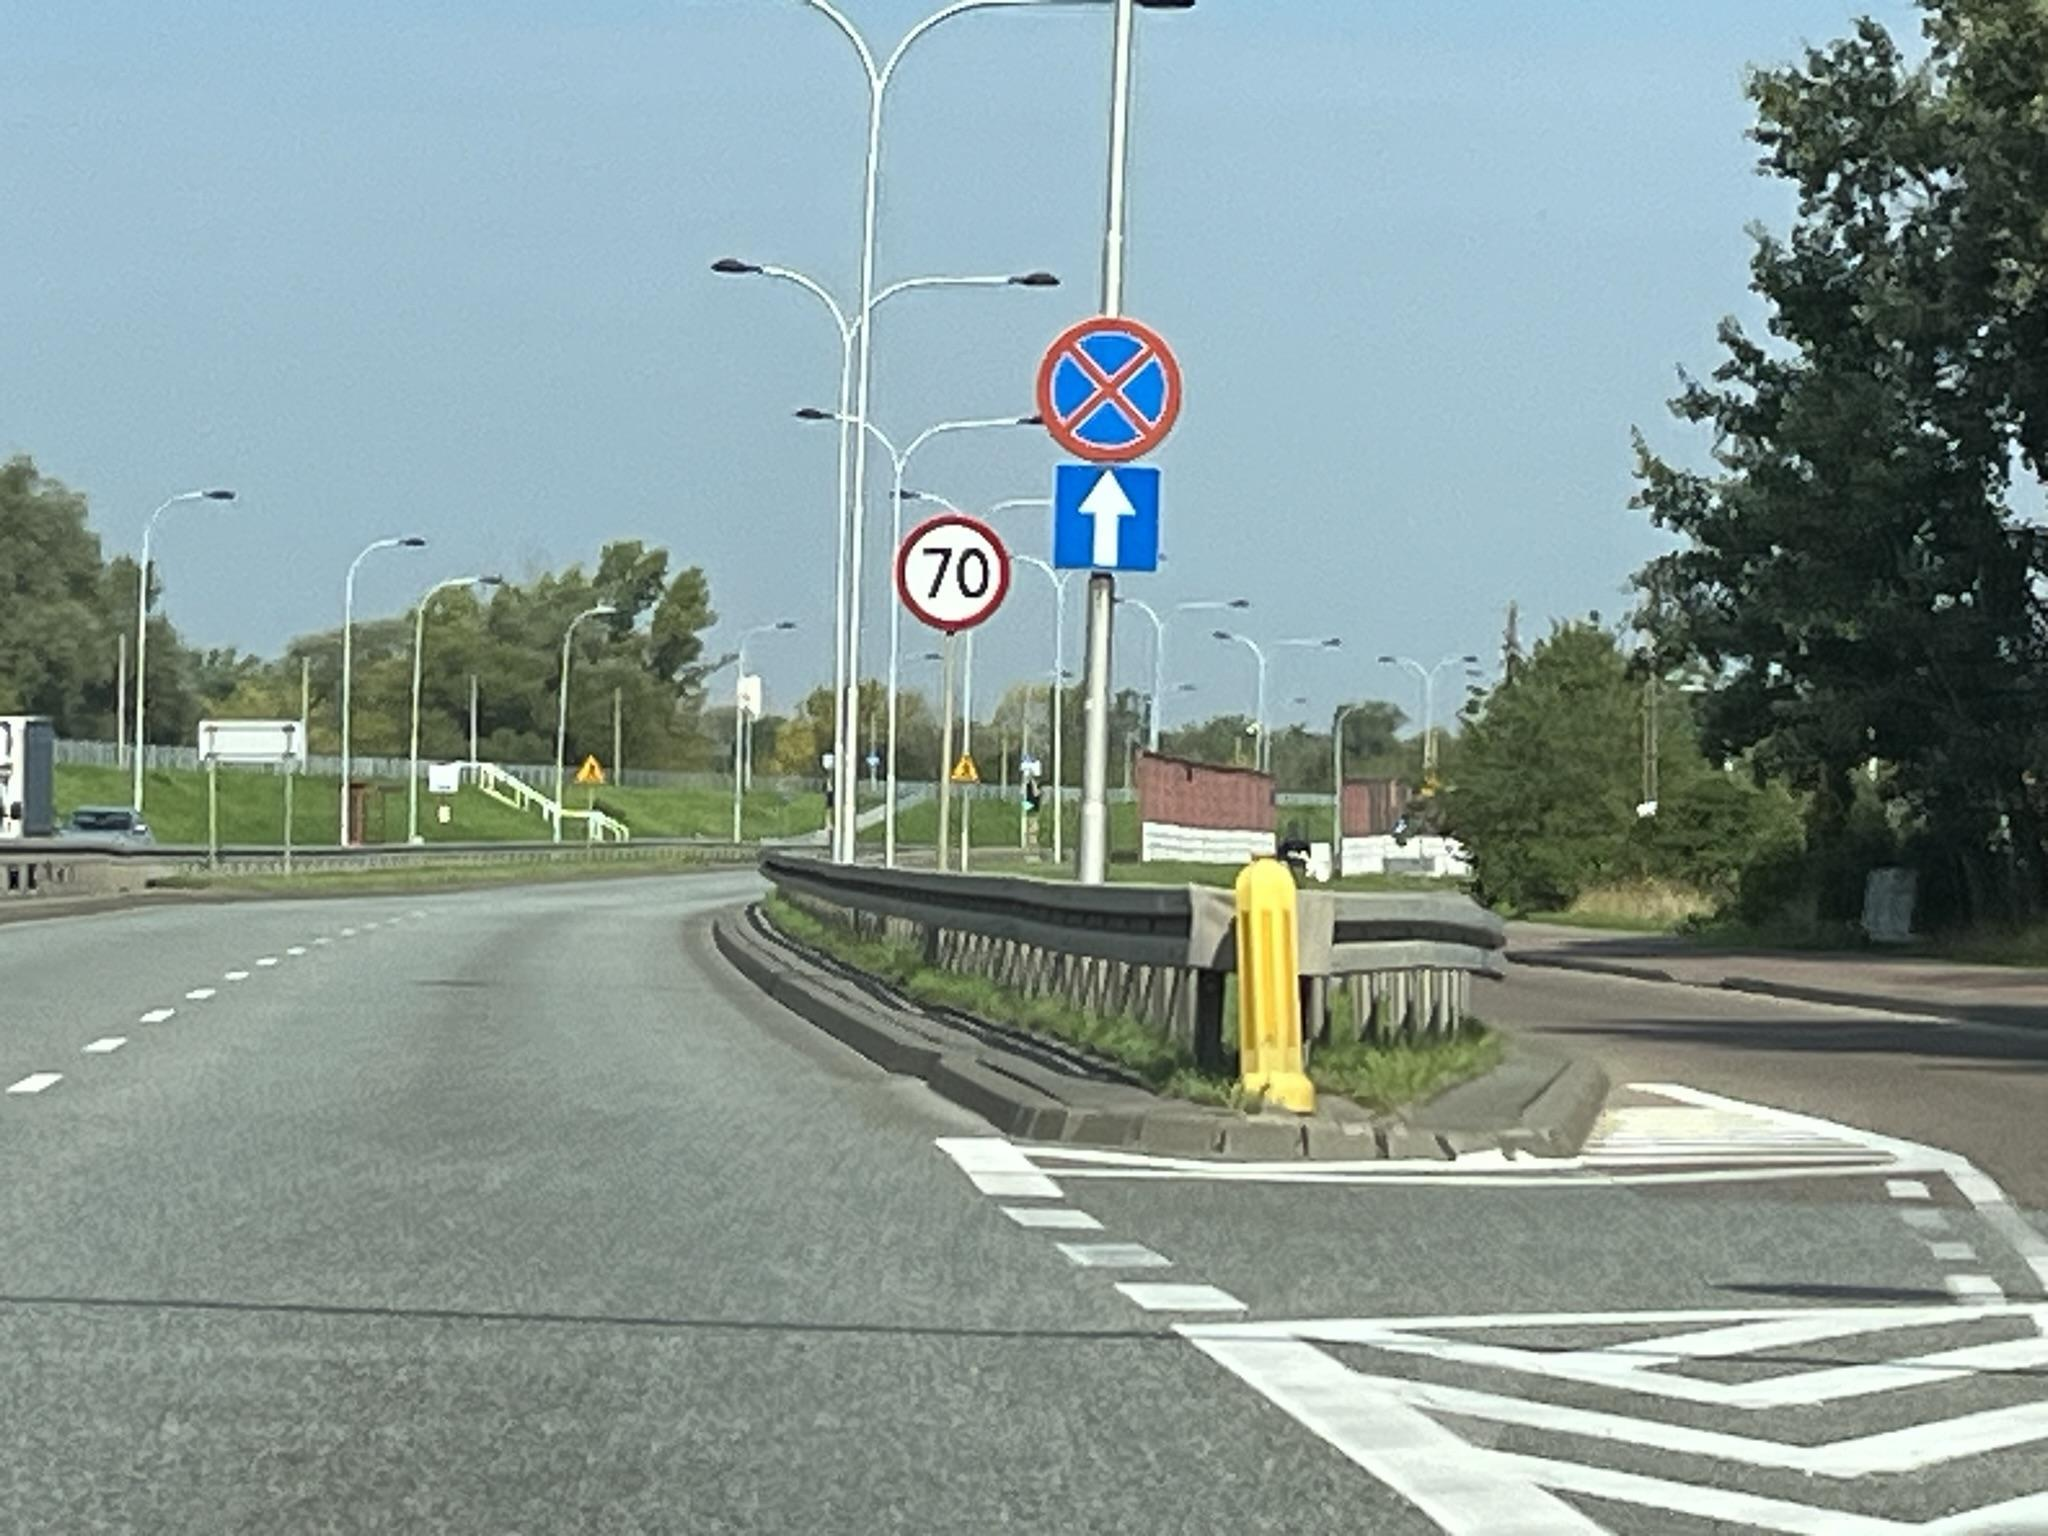


image 1/1 /kaggle/working/datasets/detection/test/1271.jpg: 480x640 3 signs, 53.1ms
Speed: 10.5ms preprocess, 53.1ms inference, 423.2ms postprocess per image at shape (1, 3, 480, 640)


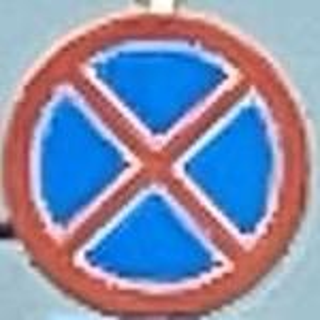

----------------------------------------------------------------------------------
Model predicted: B-36 | Class name: Zakaz zatrzymywania się
----------------------------------------------------------------------------------


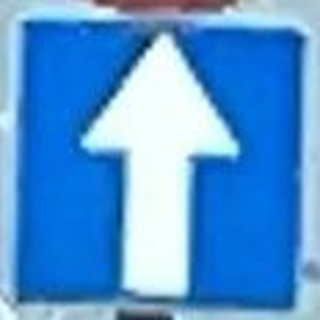

----------------------------------------------------------------------------------
Model predicted: D-3 | Class name: Droga jednokierunkowa
----------------------------------------------------------------------------------


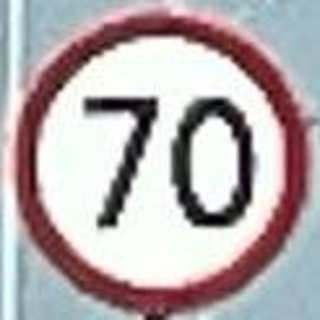

----------------------------------------------------------------------------------
Model predicted: B-33 | Class name: Ograniczenie prędkości
----------------------------------------------------------------------------------


In [34]:
import gc
gc.collect()
torch.cuda.empty_cache()

predict_with_hybrid_model(random_jpg_file_path)

# Final Prediction on Dataset from a Car Camera

In [38]:
import re

def split_categories(file_name):
    name_without_extension = file_name.split('.')[0]
    categories = re.findall(r'[A-Za-z]+-\d+', name_without_extension)
    return categories

print(split_categories("A-16B-5"))

['A-16', 'B-5']


In [39]:
def predict_with_hybrid_model_test(random_image_path):
    file_name = os.path.basename(random_image_path)
    categories = split_categories(file_name)
    categories_str = ', '.join(categories)
    
    random_image = Image.open(random_image_path)
    display(random_image)
    
    # YOLOv8 Model for sign detection
    model_yolo = YOLO("/kaggle/input/yolov8/tensorflow2/v1/1/best.pt")
    cropped_images_list = crop_and_save_objects(random_image_path, model_yolo)
    
    # Prediction of traffic sign class with CNN
    model_cnn = load_model('/kaggle/input/cnn/tensorflow2/best/1/model_best.h5')
    print('----------------------------------------------------------------------------------')
    print(f'Real signs on image: {categories_str}')
    print('----------------------------------------------------------------------------------')
    
    for cropped_image_path in cropped_images_list:
        # Predykcja za pomocą CNN
        cropped_image = Image.open(cropped_image_path)
        display(cropped_image.resize((320, 320)))
        resized_cropped_image = cropped_image.resize((32, 32))
        image_array = np.array(resized_cropped_image.convert('RGB'))
        image_array.shape = (1, 32, 32, 3)
        result = model_cnn.predict(image_array, verbose=0)

        predicted_class_index = np.argmax(result)

        predicted_class_name = list(test_data_generator.class_indices.keys())[predicted_class_index]

        predicted_class_name_desc = class_names[predicted_class_name]

        print('----------------------------------------------------------------------------------')
        print(f'Model predicted: {predicted_class_name} | Class name: {predicted_class_name_desc}')
        print('----------------------------------------------------------------------------------')

In [98]:
directory_path = '/kaggle/input/final-test/'
jpg_files = [file for file in os.listdir(directory_path) if file.endswith('.jpg')]
random_jpg_file = random.choice(jpg_files)
random_jpg_file_path = directory_path + random_jpg_file

print("Losowo wybrany plik JPG:", random_jpg_file_path)

Losowo wybrany plik JPG: /kaggle/input/final-test/B-20C-2.jpg


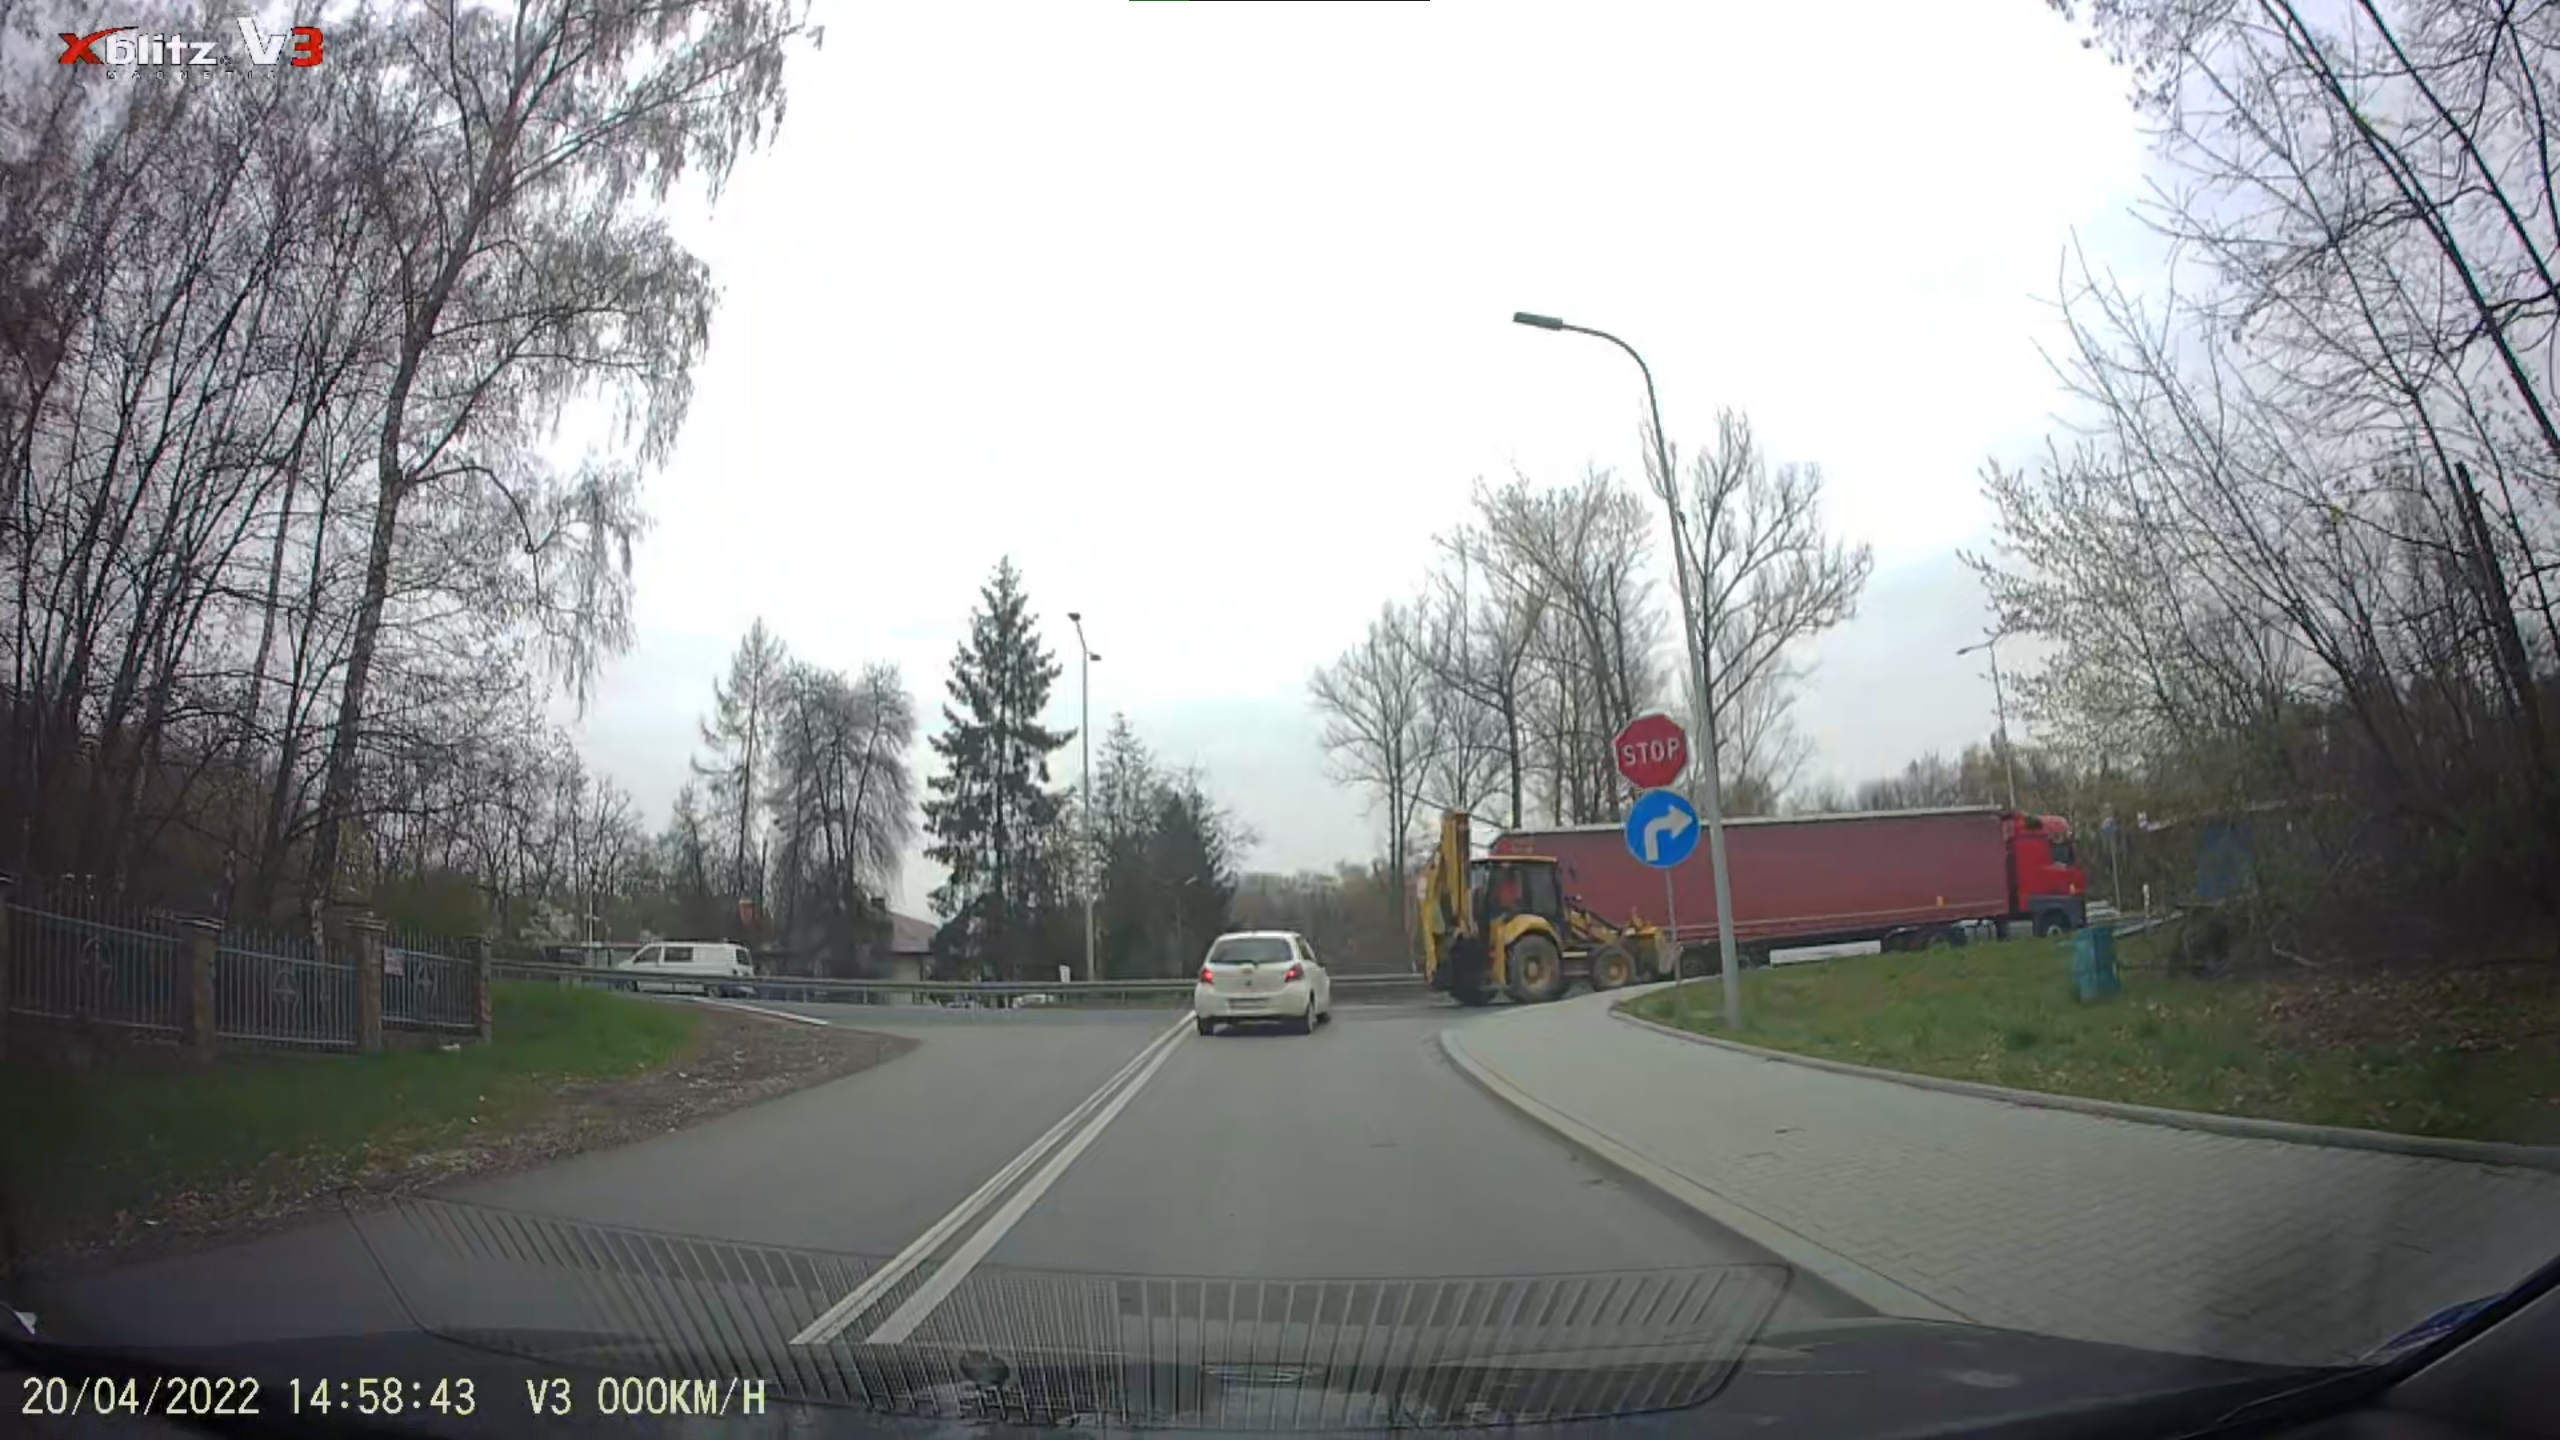


image 1/1 /kaggle/input/final-test/B-20C-2.jpg: 384x640 2 signs, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
----------------------------------------------------------------------------------
Real signs on image: B-20, C-2
----------------------------------------------------------------------------------


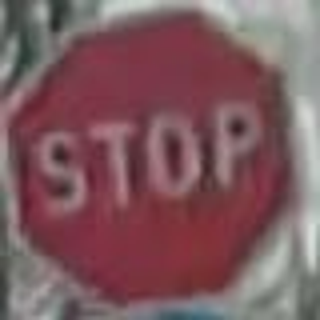

----------------------------------------------------------------------------------
Model predicted: B-20 | Class name: STOP
----------------------------------------------------------------------------------


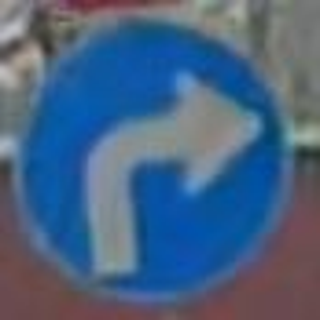

----------------------------------------------------------------------------------
Model predicted: D-18 | Class name: Parking
----------------------------------------------------------------------------------


In [99]:
import gc
gc.collect()
torch.cuda.empty_cache()

predict_with_hybrid_model_test(random_jpg_file_path)